In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv', index_col='Unnamed: 0')

In [4]:
from ModelTesters.BaselineModelTester import BaselineModelTester
from AutoValidator.ErrorMetrics import calculate_all_errors

In [44]:
init_h = []

for name in data.columns:
#     if '_1_' in name:
    print(name)
#         print(hurst_estimates.loc[name]['avg'])
    init_h += [hurst_estimates.loc[name]['avg']]
        
print(min(init_h), max(init_h))

window_1_0
window_1_1
window_1_2
window_1_3
window_1_4
window_1_5
window_1_6
window_1_7
window_1_8
window_1_9
window_1_10
window_1_11
window_1_12
window_1_13
window_1_14
window_10_0
window_10_1
window_10_2
window_10_3
window_10_4
window_10_5
window_10_6
window_10_7
window_10_8
window_10_9
window_10_10
window_10_11
window_10_12
window_10_13
window_10_14
window_30_0
window_30_1
window_30_2
window_30_3
window_30_4
window_30_5
window_30_6
window_30_7
window_30_8
window_30_9
window_30_10
window_30_11
window_30_12
window_30_13
window_30_14
window_45_0
window_45_1
window_45_2
window_45_3
window_45_4
window_45_5
window_45_6
window_45_7
window_45_8
window_45_9
window_45_10
window_45_11
window_45_12
window_45_13
window_45_14
0.8354827042225752 0.9176065970988488


Text(0,0.5,'Hurst Exponent (H)')

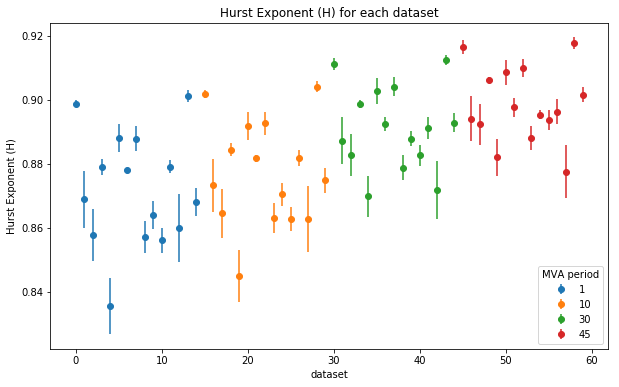

In [61]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.errorbar(x=np.arange(0, 15), y=hurst_estimates['avg'][0:15], yerr=hurst_estimates['std'][0:15], fmt='o')
plt.errorbar(x=np.arange(15, 30), y=hurst_estimates['avg'][15:30], yerr=hurst_estimates['std'][15:30], fmt='o')
plt.errorbar(x=np.arange(30, 45), y=hurst_estimates['avg'][30:45], yerr=hurst_estimates['std'][30:45], fmt='o')
plt.errorbar(x=np.arange(45, 60), y=hurst_estimates['avg'][45:60], yerr=hurst_estimates['std'][45:60], fmt='o')
plt.legend(["1", "10", "30", "45"], title="MVA period")
plt.title("Hurst Exponent (H) for each dataset")
plt.xlabel("dataset")
plt.ylabel("Hurst Exponent (H)")

## Random Walk on each dataset

In [5]:
class RandomWalk():
    
    def __init__(self, horizon):
        self.horizon = horizon
    
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        comb_data = np.hstack([self.train, data])
        
        results = np.zeros((len(data), self.horizon))
        
        std = np.std(comb_data)
        
        results[:, 0] = data[:]
        
        noise = np.random.normal(0, std, (len(data), self.horizon))
        results += noise        
        
        return results.cumsum(axis=1)
    
    def __repr__(self):
        return 'Random Walk'

In [6]:
walk = RandomWalk(5)

In [7]:
d = np.arange(0, 100)

In [8]:
walk.fit(d[:80], d[:80])

In [9]:
a = walk.predict(d[80:])

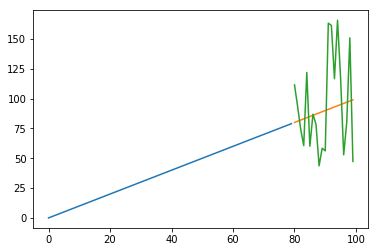

In [10]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

## Mean estimation

In [11]:
class MeanEstimator():
    
    def __init__(self, horizon):
        self.horizon = horizon
        
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        return np.repeat( pd.Series(np.hstack([self.train, data])).expanding().mean()[len(self.train):], self.horizon).values.reshape(len(data), self.horizon)    

    def __repr__(self):
        return 'Mean Estimator'

In [12]:
me = MeanEstimator(5)

In [13]:
d = np.arange(0, 100)

In [14]:
me.fit(d[:80], d[:80])

In [15]:
a = me.predict(d[80:])

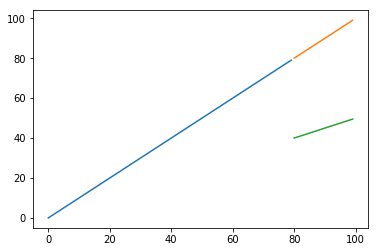

In [16]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

## Moving Average Estimator

In [17]:
class MovingAvgEstimator():
    
    def __init__(self, horizon, back_horizon=None):
        self.horizon = horizon
        
        if back_horizon is None:
            back_horizon = horizon
        self.back_horizon = back_horizon
        
    def fit(self, train, labels):
        self.starting_horizon = labels[-(self.back_horizon - 1):]
        
    def predict(self, data):
        comb_data = np.hstack([self.starting_horizon, data])
        
        return np.repeat(pd.Series(comb_data).rolling(self.back_horizon).mean().dropna(axis=0).values, self.horizon).reshape(len(data), self.horizon)
    
    def __repr__(self):
        return 'Moving Avg Estimator: (h={:d})'.format(self.horizon)

In [18]:
mva = MovingAvgEstimator(5, 30)

In [19]:
d = np.arange(0, 100)
rand = 1.0 * np.random.randn(100) + 0
rand = np.cumsum(rand)

In [20]:
d[80:]

array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
       97, 98, 99])

In [21]:
mva.fit(d[:80], d[:80])

In [22]:
a = mva.predict(d[80:])

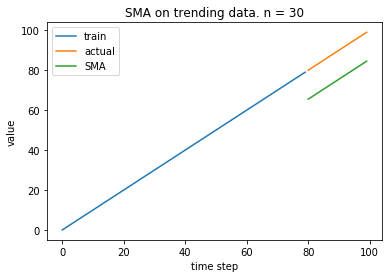

In [23]:
%matplotlib inline
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

plt.xlabel('time step')
plt.ylabel('value')
plt.title('SMA on trending data. n = 30')
plt.legend(['train', 'actual', 'SMA'])

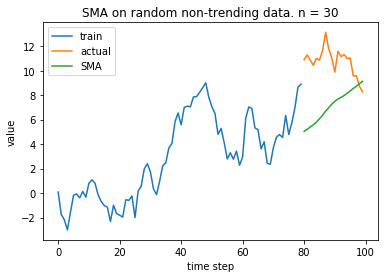

In [24]:
# On random data
mva = MovingAvgEstimator(5, 30)
mva.fit(rand[:80], rand[:80])
a = mva.predict(rand[80:])

%matplotlib inline
plt.plot(np.arange(80), rand[:80])
plt.plot(np.arange(80, 100), rand[80:])
plt.plot(np.arange(80, 100), a[:, 1])

plt.xlabel('time step')
plt.ylabel('value')
plt.title('SMA on random non-trending data. n = 30')
plt.legend(['train', 'actual', 'SMA'])

In [25]:
def speed_up_calc(tester, data, horizon):
    # Loading bar
    tester.progressBar.set_length(len(data.columns))

    # walk speed up
    for i, column in enumerate(data.columns):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]

        tester.model.fit(train, train)
        pred = tester.model.predict(test)
        tester.predictions[column] = pred

        errors = {}
        for key, value in calculate_all_errors(train, test, pred, horizon).items():
            errors[key] = [value]

        t = pd.DataFrame.from_dict(errors)
        t.set_index(keys=[[column]], inplace=True)
        tester.errors = tester.errors.append(t)

        tester.progressBar.progress()

# Forecasting

In [26]:
%matplotlib notebook

## 1 minute horizon

In [27]:
horizon = 1

one_min_walk = RandomWalk(horizon)
one_min_mean = MeanEstimator(horizon)
one_min_mva = MovingAvgEstimator(horizon, 15)

In [ ]:
one_min_walk_tester = BaselineModelTester(data, one_min_walk, horizon, 0.20)
speed_up_calc(one_min_walk_tester, data, horizon)

In [29]:
one_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,297.371949,372.617489,579.454616,105.666136,1.250378,933.14995,1.009183
window_1_1,303.427924,380.618655,1262.602039,106.353257,1.506576,349.16037,1.016094
window_1_2,343.100395,430.391193,813.245827,108.305021,1.108164,-238.96775,1.054729
window_1_3,383.095621,480.622113,559.743699,102.201419,0.980806,175.39842,0.995204
window_1_4,331.436861,415.983790,1343.657110,116.174711,1.106803,465.88498,1.148341


(0.0, 800)

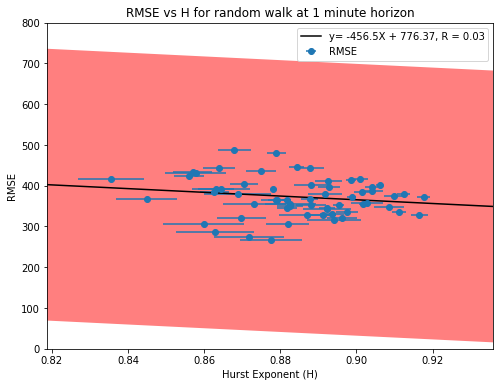

In [58]:
%matplotlib inline
one_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for random walk at 1 minute horizon')
plt.ylim([0.0, 800])
# plt.savefig('results/images/one_min_walk_hurst_comp.png')

In [ ]:
one_min_walk_tester.errors.to_csv('results/one_minute_random_walk_results.csv')

In [63]:
one_min_mean_tester = BaselineModelTester(data, one_min_mean, horizon, 0.20)
speed_up_calc(one_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [64]:
one_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,294.708267,383.840209,100.394376,198.038759,1.239178,924.79135,1.000144
window_1_1,298.553692,396.919130,102.295595,198.005408,1.482374,343.55149,0.999772
window_1_2,325.316326,427.998295,100.834025,197.182665,1.050724,-226.58124,1.000058
window_1_3,384.556657,474.143761,100.827081,196.979884,0.984546,176.06735,0.999000
window_1_4,288.599218,414.853780,106.940037,195.603028,0.963750,405.67015,0.999920


(-50, 800)

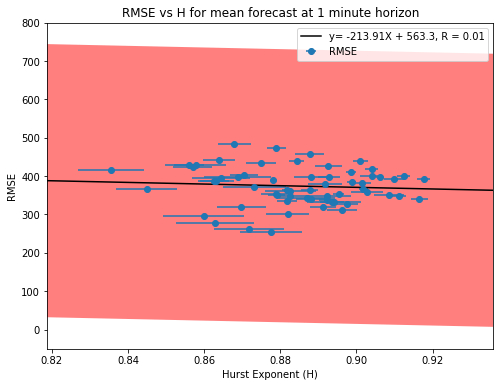

In [70]:
one_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for mean forecast at 1 minute horizon')
plt.ylim([-50, 800])

In [131]:
one_min_mean_tester.errors.to_csv('results/one_minute_mean_results.csv')

In [28]:
one_min_mva_tester = BaselineModelTester(data, one_min_mva, horizon, 0.20)
speed_up_calc(one_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


<IPython.core.display.Javascript object>


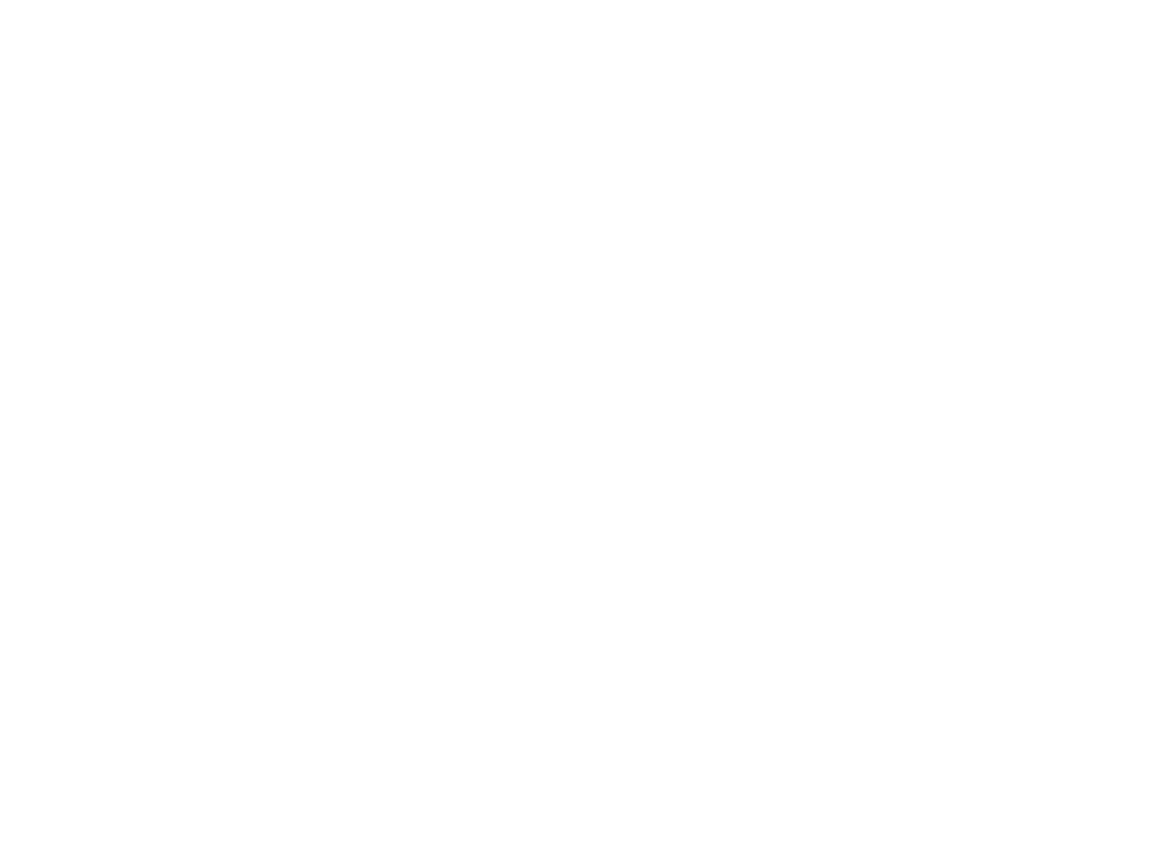

(-0.3, 0.9)

<IPython.core.display.Javascript object>


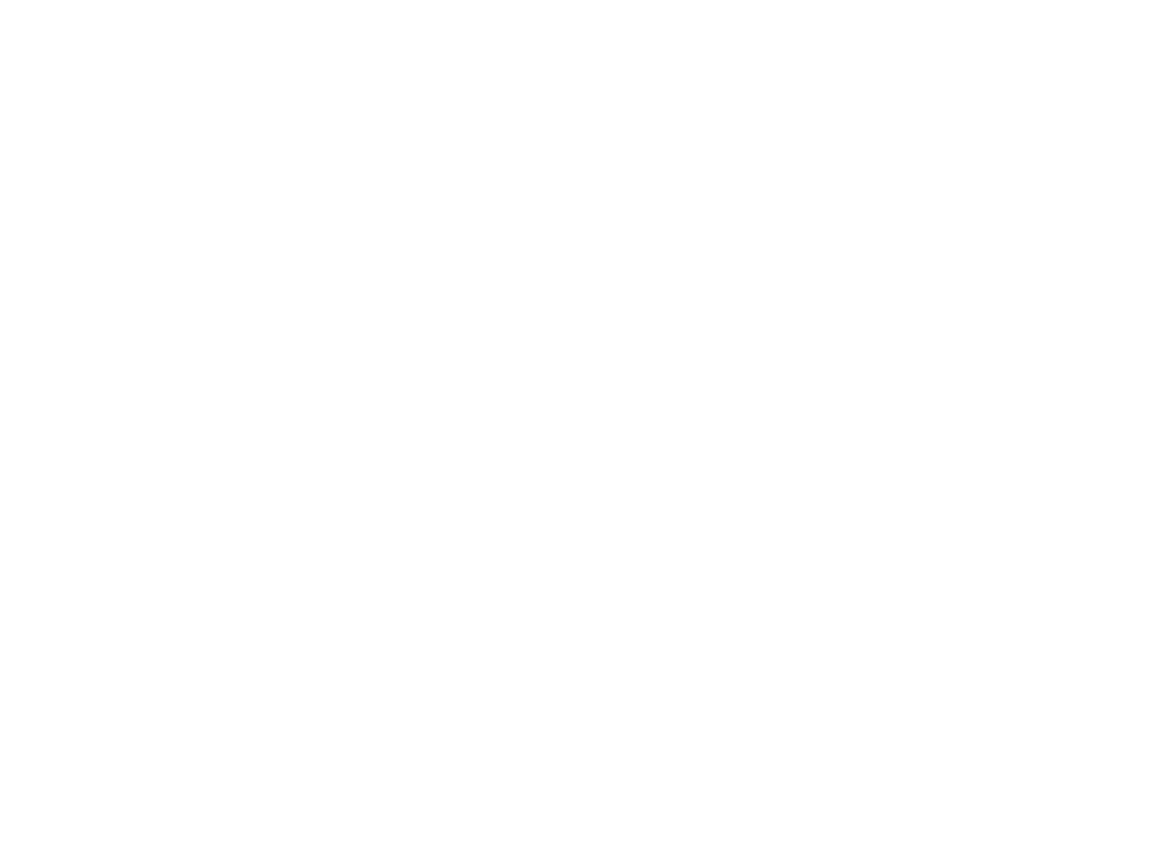

In [29]:
one_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for SMA at 1 minute horizon')
plt.ylim([-0.3, 0.9])

In [55]:
one_min_mva_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE,RMSE avg,RMSE std
window_1_0,61.903223,163.040360,70.210783,25.191812,0.260288,194.25164,0.210079,163.040360,NaN
window_1_1,69.075982,203.610038,62.901886,23.208126,0.342975,79.48707,0.231316,203.610038,NaN
window_1_2,95.190428,231.326460,130.176008,31.404616,0.307451,-66.29967,0.292626,231.326460,NaN
window_1_3,101.327250,243.014126,94.969074,30.051650,0.259419,46.39218,0.263228,243.014126,NaN
window_1_4,112.721159,269.806095,229.511888,35.737864,0.376422,158.44675,0.390549,269.806095,NaN


In [133]:
one_min_mva_tester.errors.to_csv('results/one_minute_mva_results.csv')

## 5 Minute horizon

In [71]:
horizon = 5

five_min_walk = RandomWalk(horizon)
five_min_mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [36]:
five_min_walk_tester = BaselineModelTester(data, five_min_walk, horizon, 0.20)
speed_up_calc(five_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [37]:
five_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,508.817749,660.687332,1132.626066,125.529012,2.139458,1596.66458,1.726684
window_1_1,519.073401,676.043580,2372.511665,126.081100,2.577295,597.30778,1.738174
window_1_2,592.958742,772.981916,1431.077783,128.179499,1.915169,-412.99287,1.822795
window_1_3,657.990289,856.424156,875.731673,123.075489,1.684594,301.25757,1.709418
window_1_4,580.402226,757.443263,3904.591805,135.247873,1.938200,815.84371,2.011100


(-0.5, 4)

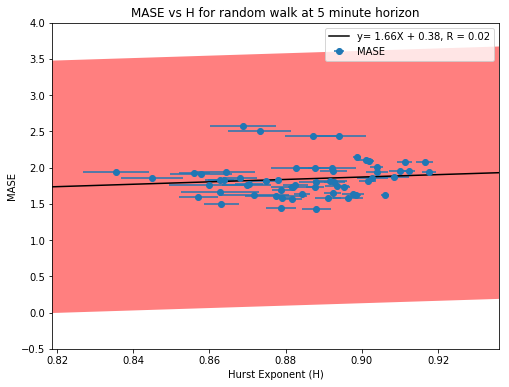

In [76]:
five_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for random walk at 5 minute horizon')
plt.ylim([-0.5, 4])

In [136]:
five_min_walk_tester.errors.to_csv('results/five_minute_random_walk_results.csv')

In [72]:
five_min_mean_tester = BaselineModelTester(data, five_min_mean, horizon, 0.20)
speed_up_calc(five_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [73]:
five_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,294.735580,383.871506,100.398976,198.047930,1.239293,924.87705,1.000191
window_1_1,298.577213,396.950630,102.300430,198.014429,1.482491,343.57856,0.999819
window_1_2,325.335164,428.026491,100.837619,197.191832,1.050784,-226.59436,1.000102
window_1_3,384.552813,474.147254,100.831235,196.989060,0.984537,176.06559,0.999044
window_1_4,288.589003,414.849820,106.944517,195.611052,0.963716,405.65579,0.999964


(-0.5, 800)

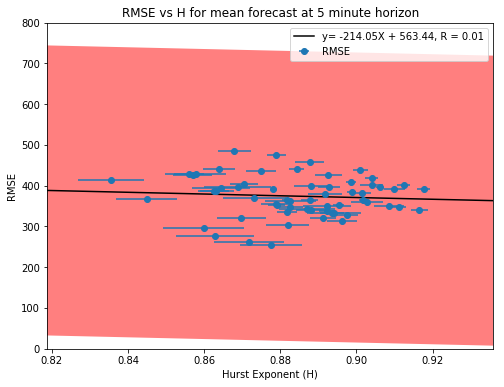

In [81]:
five_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for mean forecast at 5 minute horizon')
plt.ylim([-0.5, 800])

In [137]:
five_min_mean_tester.errors.to_csv('results/five_minute_mean_results.csv')

In [52]:
five_min_mva_tester = BaselineModelTester(data, mva, horizon, 0.20)
speed_up_calc(five_min_mva_tester, data, horizon)

Progress: [####################] 100.0%


(-0.3, 1.0)

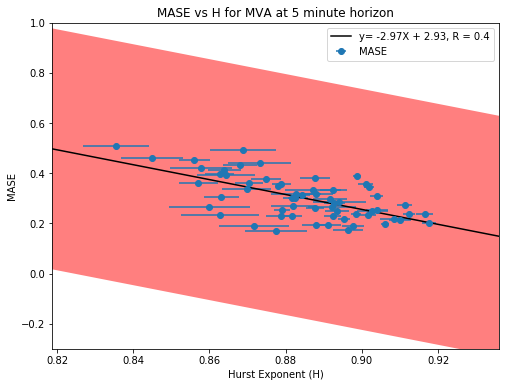

In [59]:
five_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='MASE', figsize=())
plt.title('MASE vs H for MVA at 5 minute horizon')
plt.ylim([-0.3, 1.0])

In [120]:
five_min_mva_tester.errors.head()

,MAE,MAPE,MASE,MASE1,MEAN_ASE,RMSE,RW_ASE,sMAPE
window_1_0,92.004262,115.133188,0.386856,288.70838,0.312218,208.059042,NaN,37.537537
window_1_1,99.286771,94.859098,0.492977,114.25120,0.332473,251.944313,NaN,34.478342
window_1_2,130.370188,161.372089,0.421076,-90.80220,0.400767,286.018674,NaN,43.063600
window_1_3,139.142118,118.738351,0.356233,63.70552,0.361483,298.247507,NaN,41.153721
window_1_4,151.932361,342.077881,0.507364,213.56407,0.526447,327.763359,NaN,49.662307


In [138]:
five_min_mva_tester.errors.to_csv('results/five_minute_mva_results.csv')

## 60 minute horizon

In [106]:
horizon = 60

sixty_min_walk = RandomWalk(horizon)
sixty_min_mean = MeanEstimator(horizon)
sixty_min_mva = MovingAvgEstimator(horizon, 45)

In [50]:
sixty_min_walk_tester = BaselineModelTester(data, sixty_min_walk, horizon, 0.20)
speed_up_calc(sixty_min_walk_tester, data, horizon)

Progress: [####################] 100.0%


In [51]:
sixty_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,1572.342579,2080.233241,3581.049307,158.137552,6.611327,4933.99397,5.333907
window_1_1,1608.030944,2129.054410,6792.601899,158.718329,7.984171,1850.39223,5.382880
window_1_2,1823.101337,2413.247378,4432.242017,160.064869,5.888348,-1269.78120,5.602921
window_1_3,2034.676306,2691.361286,2822.031044,157.181251,5.209202,931.56640,5.289229
window_1_4,1777.254558,2351.785944,14096.987373,164.417816,5.934978,2498.20191,6.159889


(0, 4500)

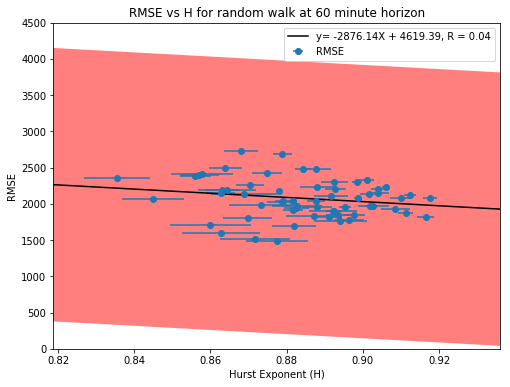

In [56]:
sixty_min_walk_tester.compare_hurst(hurst_estimates, err_to_use='RMSE')
plt.title('RMSE vs H for random walk at 60 minute horizon')
plt.ylim([0, 4500])

In [139]:
sixty_min_walk_tester.errors.to_csv('results/sixty_minute_random_walk_results.csv')

In [107]:
sixty_min_mean_tester = BaselineModelTester(data, sixty_min_mean, horizon, 0.20)
speed_up_calc(sixty_min_mean_tester, data, horizon)

Progress: [####################] 100.0%


In [108]:
sixty_min_mean_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,295.001364,384.186327,100.450509,198.177185,1.240411,925.71108,1.000742
window_1_1,298.831773,397.267062,102.366094,198.137860,1.483755,343.87149,1.000339
window_1_2,325.561436,428.307949,100.896857,197.306237,1.051515,-226.75195,1.000545
window_1_3,384.494467,474.092346,100.883576,197.099311,0.984387,176.03887,0.999510
window_1_4,288.611209,414.884364,107.109562,195.693513,0.963791,405.68700,1.000314


(-0.6, 2.7)

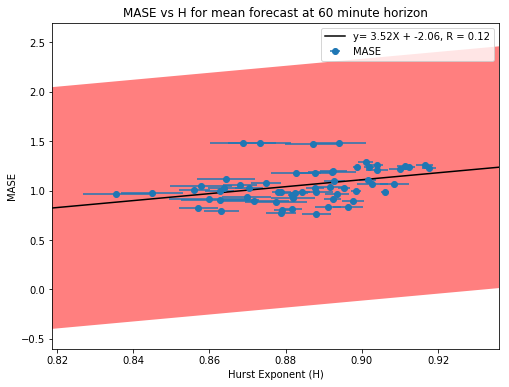

In [116]:
sixty_min_mean_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for mean forecast at 60 minute horizon')
plt.ylim([-0.6, 2.7])

In [140]:
sixty_min_mean_tester.errors.to_csv('results/sixty_minute_mean_results.csv')

In [83]:
sixty_min_mva_tester = BaselineModelTester(data, sixty_min_mva, horizon, 0.20)
speed_up_calc(sixty_min_mva_tester, data, horizon)

(69000, 5) (69000, 60)


ValueError: Found input variables with inconsistent numbers of samples: [345000, 4140000]

(-0.2, 1.4)

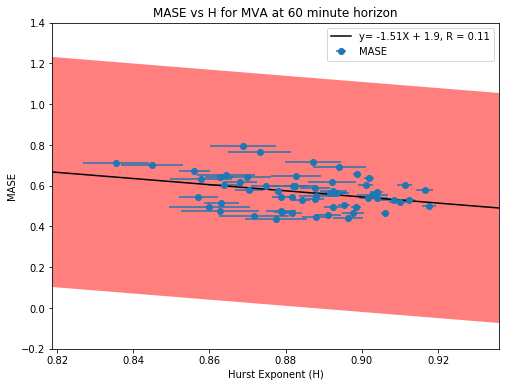

In [73]:
sixty_min_mva_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for MVA at 60 minute horizon')
plt.ylim([-0.2, 1.4])

In [62]:
sixty_min_mva_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,92.004262,208.059042,115.133188,37.537537,0.386856,288.70838,0.312218
window_1_1,99.286771,251.944313,94.859098,34.478342,0.492977,114.25120,0.332473
window_1_2,130.370188,286.018674,161.372089,43.063600,0.421076,-90.80220,0.400767
window_1_3,139.142118,298.247507,118.738351,41.153721,0.356233,63.70552,0.361483
window_1_4,151.932361,327.763359,342.077881,49.662307,0.507364,213.56407,0.526447


In [141]:
sixty_min_mva_tester.errors.to_csv('results/sixty_minute_mva_results.csv')

In [83]:
horizon = 5
one_min_walk_tester = ModelTester(data, walk, horizon, 0.20)
speed_up_calc(one_min_walk_tester, data, horizon)

one_min_walk_tester.errors.head()

one_min_mean_tester = ModelTester(data, mean, horizon, 0.20)
speed_up_calc(one_min_mean_tester, data, horizon)

one_min_mean_tester.errors.head()

one_min_mva_tester = ModelTester(data, mva, horizon, 0.20)
speed_up_calc(one_min_mva_tester, data, horizon)

one_min_mva_tester.errors.head()
walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [84]:
five_min_walk_tester = ModelTester(data, walk, horizon, 0.20)

In [76]:
# Loading bar
one_min_walk_tester.progressBar.set_length(len(data.columns))

# walk speed up
for i, column in enumerate(data.columns):
    # Split into train and test data
    split = int(0.20 * len(data))
    train, test = data[column][:split].values, data[column][split:].values
    # Round to be a multiple of the horizon
    test = test[:len(test) - len(test) % horizon]
    
    one_min_walk_tester.model.fit(train, train)
    pred = one_min_walk_tester.model.predict(test)
    one_min_walk_tester.predictions[column] = pred
    
    errors = {}
    for key, value in calculate_all_errors(train, test, pred, horizon).items():
        errors[key] = [value]
    
    t = pd.DataFrame.from_dict(errors)
    t.set_index(keys=[[column]], inplace=True)
    one_min_walk_tester.errors = one_min_walk_tester.errors.append(t)
    
    one_min_walk_tester.progressBar.progress()

Progress: [####################] 100.0%


In [78]:
one_min_walk_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE,RW_ASE
window_1_0,296.632363,371.738702,651.538015,105.270596,1.247269,930.82914,1.006685,0.741982
window_1_1,303.992844,380.932488,1760.638916,106.746890,1.509381,349.81043,1.017990,0.747234
window_1_2,344.230883,431.003083,818.202024,108.429280,1.111815,-239.75513,1.058202,0.746585
window_1_3,383.129354,480.089837,542.777229,102.342638,0.980892,175.41386,0.995280,0.743181
window_1_4,334.262809,419.057095,1966.866634,116.520042,1.116240,469.85728,1.158104,0.743676


In [66]:
# results = one_min_tester.test_models()

# Loading bar
one_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
one_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    train, test = train.values, test.values
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    one_min_tester.results[repr(walk)][column] = pred
    
    errors = calculate_all_errors()
    one_min_tester.errors
    
    one_min_tester.progressBar.progress()

# Mean speed up
one_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    one_min_tester.results[repr(mean)][column] = pred
    one_min_tester.progressBar.progress()
    
# MVA speed up
one_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    one_min_tester.results[repr(mva)][column] = pred
    one_min_tester.progressBar.progress()
    
    
one_min_tester.add_model(walk)
one_min_tester.add_model(mean)
one_min_tester.add_model(mva)

Progress: [####################] 100.0%


In [259]:
one_min_errors = one_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [260]:
one_min_errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=1)_RMSE,Moving Avg Estimator: (h=1)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,370.533968,1.004252,383.837483,1.000144,163.039179,0.210079,305.803544,123.816371,0.738158,0.457335
window_1_1,379.806208,1.014568,396.917204,0.999950,203.608563,0.231355,326.777325,107.009834,0.748624,0.448028
window_1_2,430.624012,1.055514,427.997371,0.999772,231.324784,0.292538,363.315389,114.314761,0.782608,0.425328
window_1_3,482.762616,1.000951,474.148053,0.999513,243.012425,0.263358,399.974365,136.001252,0.754607,0.425435
window_1_4,418.734964,1.158180,414.860941,0.999991,269.804186,0.390564,367.800030,84.888993,0.849578,0.405310


In [261]:
one_min_errors.to_csv('results/one_minute_baseline_results.csv')

Progress: [####################] 100.0%


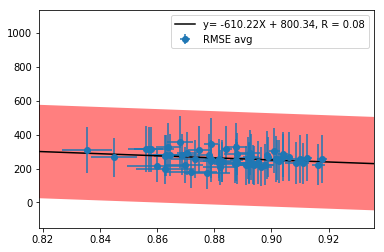

In [263]:
one_min_tester.compare_hurst(hurst_estimates)

## 5 minute horizon

In [244]:
horizon = 5

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [245]:
five_min_tester = ModelTester(data, horizon, 0.20)

# five_min_tester.add_model(walk)
# five_min_tester.add_model(mean)
# five_min_tester.add_model(mva)

In [247]:
# results = five_min_tester.test_models()

# Loading bar
five_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
five_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    five_min_tester.results[repr(walk)][column] = pred
    five_min_tester.progressBar.progress()

# Mean speed up
five_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    five_min_tester.results[repr(mean)][column] = pred
    five_min_tester.progressBar.progress()
    
# MVA speed up
five_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    five_min_tester.results[repr(mva)][column] = pred
    five_min_tester.progressBar.progress()
    
    
five_min_tester.add_model(walk)
five_min_tester.add_model(mean)
five_min_tester.add_model(mva)


Progress: [####################] 100.0%


In [248]:
errors = five_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [249]:
errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=5)_RMSE,Moving Avg Estimator: (h=5)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,661.263658,1.727968,383.861537,1.000191,208.020821,0.312315,417.715339,228.510016,1.013492,0.707920
window_1_1,679.470486,1.742633,396.939533,0.999996,251.951506,0.332516,442.787175,217.415787,1.025049,0.705392
window_1_2,775.806363,1.828303,428.017916,0.999817,286.065923,0.400614,496.630068,251.976477,1.076245,0.716906
window_1_3,857.250337,1.713267,474.160543,0.999559,298.229288,0.361694,543.213389,285.836238,1.024840,0.676141
window_1_4,757.849641,2.009544,414.865606,1.000035,327.760376,0.526636,500.158541,227.377126,1.178738,0.757433


In [250]:
errors.to_csv('results/baseline_five_minutes_results.cssv')

Progress: [####################] 100.0%


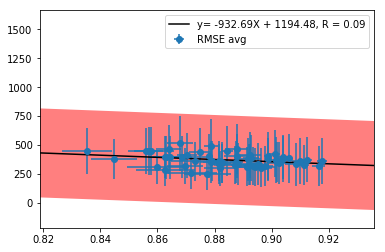

In [251]:
five_min_tester.compare_hurst(hurst_estimates)

## 60 minute horizon

In [273]:
horizon = 60

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 15)

In [274]:
sixty_min_tester = ModelTester(data, horizon, 0.20)

# sixty_min_tester.add_model(walk)
# sixty_min_tester.add_model(mean)
# sixty_min_tester.add_model(mva)

In [275]:
# results = sixty_min_tester.test_models()

# Loading bar
sixty_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
sixty_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    sixty_min_tester.results[repr(walk)][column] = pred
    sixty_min_tester.progressBar.progress()

# Mean speed up
sixty_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    sixty_min_tester.results[repr(mean)][column] = pred
    sixty_min_tester.progressBar.progress()
    
# MVA speed up
sixty_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    sixty_min_tester.results[repr(mva)][column] = pred
    sixty_min_tester.progressBar.progress()
    
    
sixty_min_tester.add_model(walk)
sixty_min_tester.add_model(mean)
sixty_min_tester.add_model(mva)

Progress: [####################] 100.0%


In [276]:
sixty_min_errors = sixty_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [277]:
sixty_min_errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=60)_RMSE,Moving Avg Estimator: (h=60)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,2065.975932,5.322430,384.073938,1.000736,278.989790,0.474663,909.679887,1002.759232,2.265943,2.660033
window_1_1,2147.844412,5.452250,397.132707,1.000513,328.530664,0.478586,957.835928,1031.148246,2.310450,2.733365
window_1_2,2357.930876,5.457775,428.186035,1.000261,375.524678,0.564759,1053.880530,1129.647637,2.340932,2.708034
window_1_3,2721.066358,5.349110,474.332294,1.000025,384.617480,0.502252,1193.338711,1323.811169,2.283796,2.666282
window_1_4,2320.248875,6.061397,414.946261,1.000384,408.395873,0.703408,1047.863670,1101.922779,2.588396,3.011370


In [270]:
sixty_min_errors.to_csv('results/sixty_minute_baseline_results.csv')

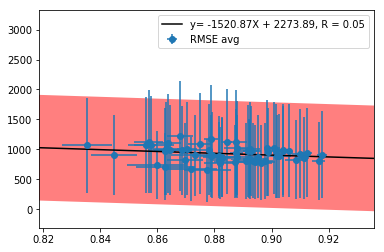

In [271]:
sixty_min_tester.compare_hurst(hurst_estimates, errors=sixty_min_errors)

<IPython.core.display.Javascript object>


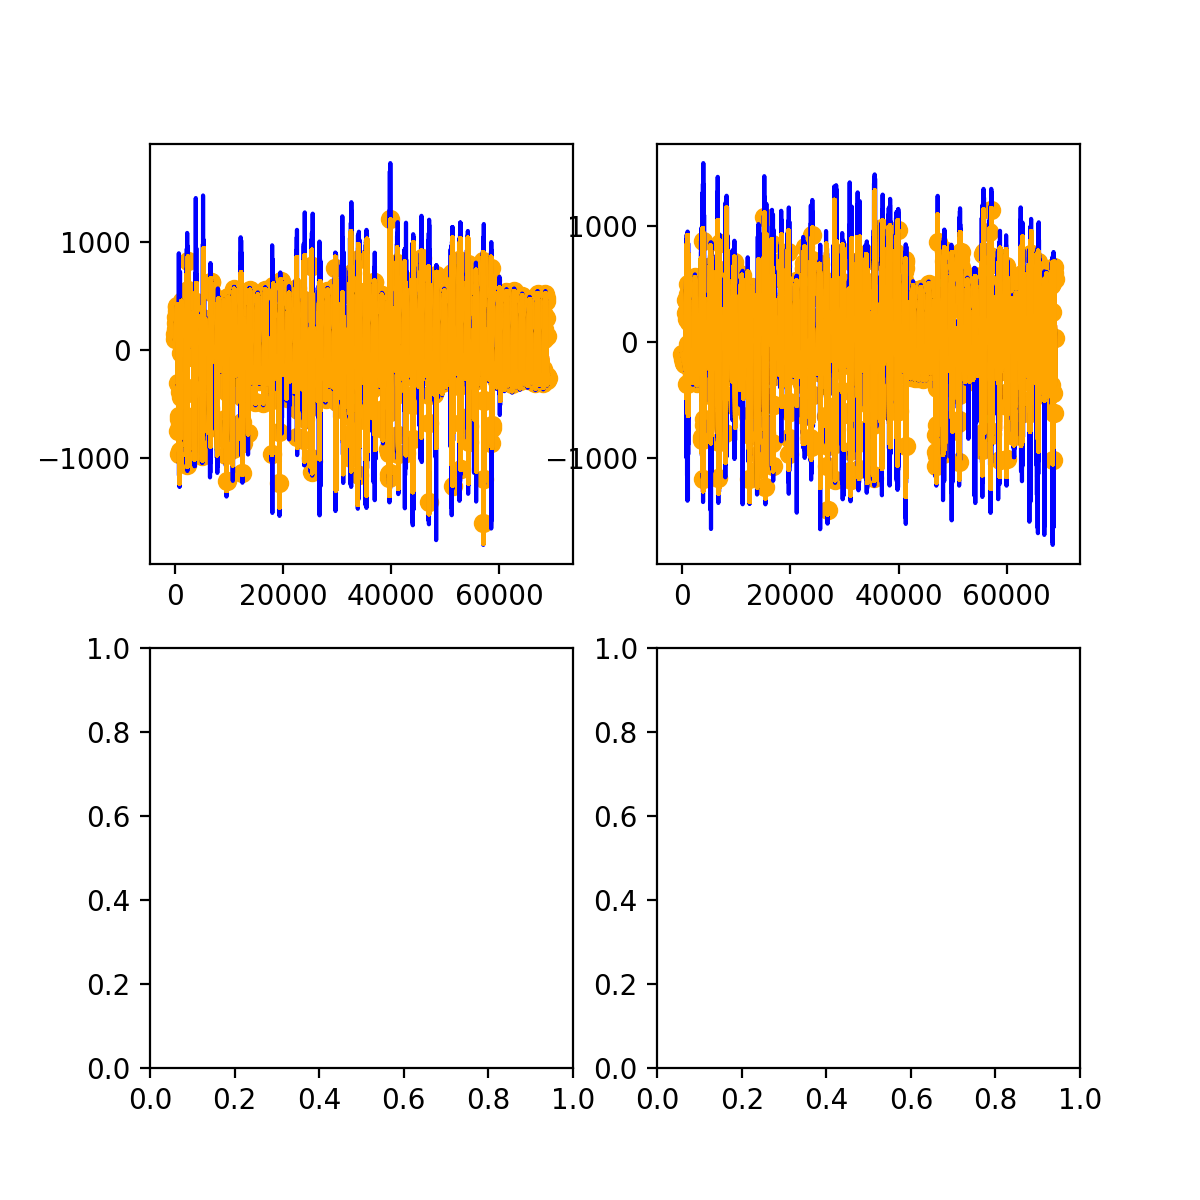

In [304]:
%matplotlib notebook
sixty_min_tester.visualise_result(repr(mva), [1, 2], figsize=(6, 6))

In [37]:
hurst_estimates.head()

,Agr Var.,Higuchi,Abs val.,avg,std
window_1_0,0.899837,0.897147,0.899166,0.898717,0.001143
window_1_1,0.857475,0.878807,0.870051,0.868778,0.008755
window_1_2,0.846924,0.866159,0.860166,0.857749,0.008036
window_1_3,0.875449,0.879919,0.881300,0.878890,0.002497
window_1_4,0.823455,0.839136,0.843857,0.835483,0.008721


In [34]:
one_min_mean_res = pd.read_csv('results/one_minute_mean_results.csv', index_col='Unnamed: 0')

In [38]:
one_min_mean_res.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE,RW_ASE
window_1_0,294.704781,383.837483,100.394378,198.038787,1.239164,924.78041,1.000144,2.572726
window_1_1,298.552672,396.917204,102.295564,198.005436,1.482369,343.55032,0.999772,2.753654
window_1_2,325.316808,427.997371,100.834016,197.182706,1.050725,-226.58157,1.000059,2.069500
window_1_3,384.561389,474.148053,100.827070,196.979927,0.984559,176.06951,0.999000,2.129180
window_1_4,288.606092,414.860941,106.939935,195.603089,0.963773,405.67981,0.999920,1.886140


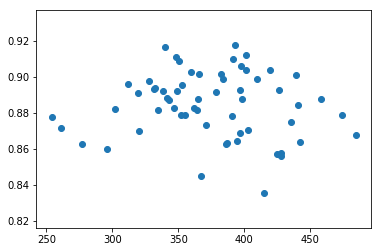

In [44]:
plt.scatter(one_min_mean_res['RMSE'], hurst_estimates['avg'])